In [103]:
import pandas as pd
import os
import json
from tqdm import tqdm
import plotly.express as px
import plotly.graph_objects as go

In [104]:
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

In [105]:
def get_demography_df():
    files = os.listdir("data/demography/")
    entries = []
    for file in tqdm(files):
        with open(f"data/demography/{file}","r") as f:
            entry = json.load(f)
            entry["frame_id"] = int(file.split("_")[1])
            entries.append(entry)
    demography_df = pd.DataFrame(entries)
    return demography_df

In [106]:
demo_df = get_demography_df()

100%|████████████████████████████████████████████████████████████████████████████| 1127/1127 [00:00<00:00, 1219.24it/s]


In [107]:
race_emotion_count = demo_df.groupby(['dominant_race', 'dominant_emotion']).size().reset_index(name='count')
# Calculate the total count for normalization
total_count = race_emotion_count['count'].sum()

# Calculate percentages
race_emotion_count['percentage'] = (race_emotion_count['count'] / total_count) * 100
race_emotion_count.head()

,dominant_race,dominant_emotion,count,percentage
0,asian,angry,4,0.354925
1,asian,fear,12,1.064774
2,asian,happy,7,0.621118
3,asian,neutral,9,0.798580
4,asian,sad,71,6.299911


In [108]:
# Get unique lists of races and emotions
unique_races = race_emotion_count['dominant_race'].unique().tolist()
unique_emotions = race_emotion_count['dominant_emotion'].unique().tolist()

# Create a mapping of race and emotion to index
race_to_index = {race: i for i, race in enumerate(unique_races)}
emotion_to_index = {emotion: i + len(unique_races) for i, emotion in enumerate(unique_emotions)}

# Apply mapping to get sources and targets
race_emotion_count['source'] = race_emotion_count['dominant_race'].map(race_to_index)
race_emotion_count['target'] = race_emotion_count['dominant_emotion'].map(emotion_to_index)


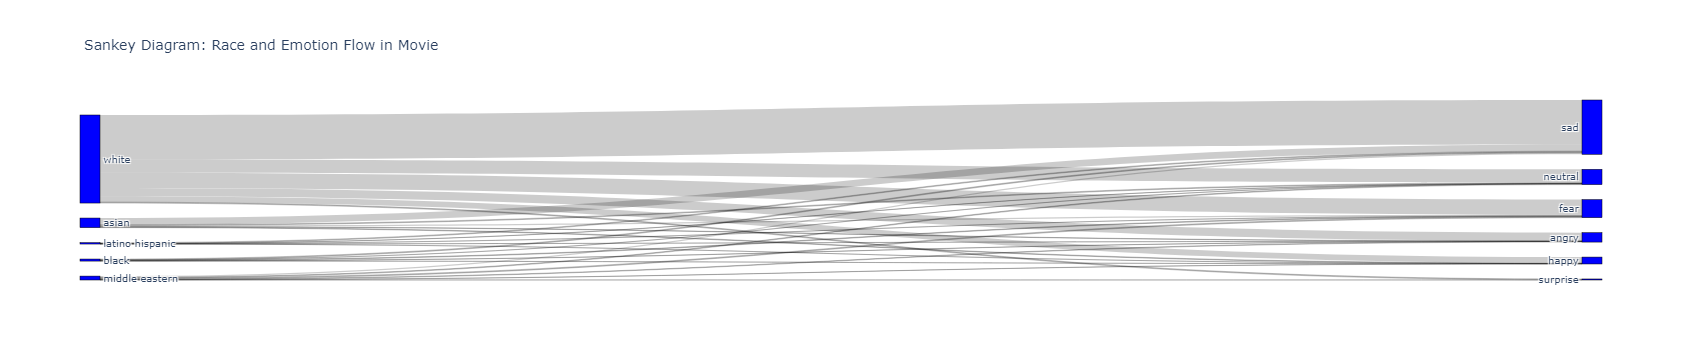

In [109]:
# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
      pad=15,
      thickness=20,
      line=dict(color="black", width=0.5),
      label=unique_races + unique_emotions,
      color="blue"
    ),
    link=dict(
      source=race_emotion_count['source'].tolist(),
      target=race_emotion_count['target'].tolist(),
      value=race_emotion_count['percentage'].tolist()
    ))])

fig.update_layout(title_text="Sankey Diagram: Race and Emotion Flow in Movie", font_size=10)
fig.show()

In [110]:
from dash import Dash, dcc, html
import dash_mantine_components as dmc
from dash.dependencies import Input, Output

In [119]:
app = Dash()

In [120]:
def get_filtered_df(selected_range):
    # Compute min and max frame_id
    min_frame_id = demo_df['frame_id'].min()
    max_frame_id = demo_df['frame_id'].max()
    range_frame_id = max_frame_id - min_frame_id
    
    # Convert percentage slider values to frame_id range
    start_id = min_frame_id + (selected_range[0] / 100.0) * range_frame_id
    end_id = min_frame_id + (selected_range[1] / 100.0) * range_frame_id
    
    # Filter the DataFrame based on the calculated frame_id range
    filtered_df = demo_df[(demo_df['frame_id'] >= start_id) & (demo_df['frame_id'] <= end_id)]
    return filtered_df

In [121]:
# Callback to update the sankey diagram based on the slider
@app.callback(
    Output('sankey-emotion-race-graph', 'figure'),
    Input('frame-slider', 'value'),
    Input('race-emotion-radio-btn', 'value'))
def update_emotion_race_sankey_graph_slider(selected_range, col_radio):
    filtered_df = get_filtered_df(selected_range)
    
    race_emotion_count = demo_df.groupby(['dominant_race', 'dominant_emotion']).size().reset_index(name='count')
    # Calculate the total count for normalization
    total_count = race_emotion_count['count'].sum()
    
    # Calculate percentages
    race_emotion_count['percentage'] = (race_emotion_count['count'] / total_count) * 100

    # Get unique lists of races and emotions
    unique_races = race_emotion_count['dominant_race'].unique().tolist()
    unique_emotions = race_emotion_count['dominant_emotion'].unique().tolist()
    
    # Create a mapping of race and emotion to index
    race_to_index = {race: i for i, race in enumerate(unique_races)}
    emotion_to_index = {emotion: i + len(unique_races) for i, emotion in enumerate(unique_emotions)}
    
    # Apply mapping to get sources and targets
    race_col = "source" if col_radio == "dominant_race" else "target"
    emotion_col = "target" if col_radio == "dominant_race" else "source"
    race_emotion_count[race_col] = race_emotion_count['dominant_race'].map(race_to_index)
    race_emotion_count[emotion_col] = race_emotion_count['dominant_emotion'].map(emotion_to_index)
    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
          pad=15,
          thickness=20,
          line=dict(color="black", width=0.5),
          label=unique_races + unique_emotions,
          color="blue"
        ),
        link=dict(
          source=race_emotion_count['source'].tolist(),
          target=race_emotion_count['target'].tolist(),
          value=race_emotion_count['percentage'].tolist()
        ))])
    
    fig.update_layout(title_text="Sankey Diagram: Race and Emotion Flow in Movie", font_size=10)
    return fig


In [122]:
# Callback to update the gender race bar graph based on the slider
@app.callback(
    Output('gender-emotion-race-bar-graph', 'figure'),
    Input('race-emotion-radio-btn', 'value'),
    Input('frame-slider', 'value'))
def update_gender_emotion_race_graph_slider(col_radio, selected_range):
    filtered_df = get_filtered_df(selected_range)
    gender_df = filtered_df.groupby([col_radio,"dominant_gender"]).size().unstack(fill_value=0)
    grouped_percent = gender_df.div(gender_df.sum(axis=1), axis=0) * 100
    title_val = "Race" if col_radio=="dominant_race" else "Emotion"
    # Plotting the stacked bar chart
    fig = go.Figure()
    
    # Add one trace for each gender
    for gender in grouped_percent.columns:
        fig.add_trace(go.Bar(
            name=gender,
            x=grouped_percent[gender],  # percentage values
            y=grouped_percent.index,  # race/emotion categories
            orientation='h'
        ))
    
    # Update layout for a stacked bar chart
    fig.update_layout(
        barmode='stack',
        title=f'Distribution of Gender by {title_val}',
        xaxis_title=f'Percentage of {title_val}',
        yaxis_title=f'{title_val}',
    )
    
    return fig

In [123]:
# Callback to update the spider graph based on the slider
@app.callback(
    Output('spider-graph', 'figure'),
    Input('frame-slider', 'value'),
    Input('race-emotion-radio-btn', 'value'))
def update_radial_graph_slider(selected_range, col_radio):
    filtered_df = get_filtered_df(selected_range)
    
    specific_df = pd.DataFrame(filtered_df[col_radio].value_counts(normalize=True)*100).reset_index()
    # Create the figure
    fig = go.Figure(data=go.Scatterpolar(
        r=specific_df['proportion'],
        theta=specific_df[col_radio],
        fill='toself'
    ))

    fig.update_layout(
        title="Percentage representation in movie segment",
        polar=dict(
            radialaxis=dict(
                visible=True
            ),
        ),
        showlegend=False
    )
    
    return fig

In [124]:
# Callback to update the line graph based on the slider
@app.callback(
    Output('evolution-line-graph', 'figure'),
    Input('frame-slider', 'value'),
    Input('race-emotion-radio-btn', 'value'))
def update_line_graph_slider(selected_range, col_radio):
    filtered_df = get_filtered_df(selected_range)
    filtered_df.loc[:,"count"] = 1
    pivot_df = filtered_df.pivot_table(index="frame_id", columns=col_radio, values="count", aggfunc="sum", fill_value=0).cumsum()
    # Create the figure
    fig = go.Figure()

    # Adding traces for each race/emotion
    for column in pivot_df.columns:
        fig.add_trace(go.Scatter(
            x=pivot_df.index,
            y=pivot_df[column],
            mode='lines',
            name=column,
            stackgroup='one' # Stacking
        ))
    
    # updating the layout
    fig.update_layout(
        title= "Representation over time in movie segment",
        xaxis_title="Frame ID",
        yaxis_title="Cumulative count of appearances",
        hovermode="x"
    )
    
    return fig

In [125]:
app.layout = html.Div([
    html.H1(children="Movie Visualizations"),
    dcc.RangeSlider(
        id='frame-slider',
        min=0,
        max=100,
        value=[0, 100],
        step=5,  # Percentage step
        marks={i: f'{i}%' for i in range(0, 101, 10)}
    ),
    html.H2(children="Distribution of Race and Emotion"),
    html.Div([
        dcc.RadioItems(
            id='race-emotion-radio-btn',
            options=[
                {'label': 'Race', 'value': 'dominant_race'},
                {'label': 'Emotion', 'value': 'dominant_emotion'}
            ],
            value='dominant_race',  # Default value
            labelStyle={'display': 'inline-block', 'margin-right': '20px'}  # Space out the buttons
        )
    ], style={'margin-bottom': '20px'}),  # Space below the radio buttons
    # Container for graphs
    html.Div([
        dcc.Graph(id='spider-graph', style={'display': 'inline-block', 'width': '50%'}),
        dcc.Graph(id='evolution-line-graph', style={'display': 'inline-block', 'width': '50%'})
    ], style={'display': 'flex'}),
    html.Div([
        dcc.Graph(id='gender-emotion-race-bar-graph', style={'display': 'inline-block', 'width': '50%'}),
        dcc.Graph(id='sankey-emotion-race-graph', style={'display': 'inline-block', 'width': '50%'})
    ], style={'display': 'flex'})
])

In [126]:
app.run(debug=True)